# Mercari Price Suggestion

## Business Problem

<h2> Description </h2>

Mercari is a Japanese community-powered shopping app where people can sell their stuff they don’t use but still has value. A typical listing on the website has product name, brand, category, shipping, condition, product description, and price. Sellers are allowed to choose any price for their product. This gives rise to the problem of setting the right price for a product. If the price is too high the product won’t find a buyer or if it’s too low then the seller will be getting less profit. So, if we can suggest a price for the given product listing, it helps the seller to set a better price for the product.  
 
For example, given sweater A and sweater B can we predict the price of the sweaters?
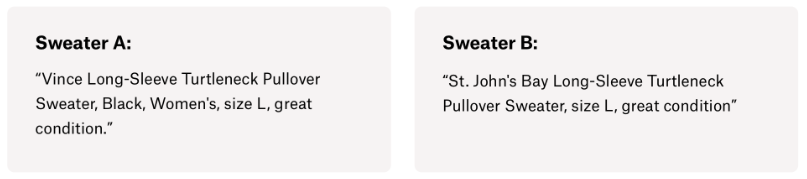

 
The price of a product may depend on many factors like, brand name, demand and supply, type of product and even picture of the product. For example, electronic products of the same category and brand may have different pricing based on small changes in specifications. 

<h2> Problem Statement </h2>

- Using Product information like name, category, brand etc Predict the price of the product.
- This result could be useful for the seller to set optimal price so his product will be sold quickly.

<h2> Sources/Useful Links</h2>

- Source : https://www.kaggle.com/c/mercari-price-suggestion-challenge
<br><br>____ Useful Links ____
- Kaggle kernel 1: https://www.kaggle.com/lopuhin/mercari-golf-0-3875-cv-in-75-loc-1900-s
- kaggle kernel 2 : https://www.kaggle.com/tunguz/more-effective-ridge-lgbm-script-lb-0-44823
- kaggle kernel 3 : https://www.kaggle.com/shivamb/extensive-text-data-feature-engineering

<h2> Real world/Business Objectives and Constraints </h2>

1. The cost of error is high. we can be off by minor margin and not too much.
2. No strict latency requirement. 
3. we have to run the code in kaggle kernel itself to make a submission.

<h1> Machine Learning Probelm </h1>

<h3> Data Overview </h3>

- Data is in two files. train.tsv and test_stg2.tsv.
    
- Each file contains columns like, train_id/test_id, name, brand, category, shipping, item_condition, item_description and price(only in train file).

</p>

<h2>Mapping the real world problem to an ML problem </h2>

<h3>Type of Machine Leaning Problem: </h3>

* It is a Regression problem. Given Product details we have to predict the price.

<h3>Performance Metric: </h3>

* Root Mean Square Logarithmc Error(RMSLE)

<h2> Approach </h2>

Features:
1. Create two new columns name_brand(name + brand) and text (item_description + name + category)
2. Extract new features like no. of words, length, subjectivity from item_description.
3. Create a feature for missing values in brand, category and item_description.

Vectorizations:
1. Use TFIDF vectorizer for text columns.
2. standard scale other numerical columns.
3. create a new dataset by converting everything to bool.

Modeling:
1. Train models like ridge regression, light gbm, MLP and MLP in bool dataset.
2. Combine the predictions of these models by training a lasso regression and submit the result as final prediction.

In [1]:
# importing libraries

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from textblob import TextBlob
from nltk.corpus import stopwords 
import re

import seaborn as sns
import matplotlib.pyplot as plt
import os


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from scipy.sparse import coo_matrix, hstack
from numpy import median


In [2]:
# list of files in the kaggle drive

for dirname, _, filenames in os.walk('/kaggle/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/lib/kaggle/gcp.py
/kaggle/input/mercari-price-suggestion-challenge/test.tsv.7z
/kaggle/input/mercari-price-suggestion-challenge/train.tsv.7z
/kaggle/input/mercari-price-suggestion-challenge/sample_submission.csv.7z
/kaggle/input/mercari-price-suggestion-challenge/sample_submission_stg2.csv.zip
/kaggle/input/mercari-price-suggestion-challenge/test_stg2.tsv.zip
/kaggle/working/__notebook_source__.ipynb


In [3]:
# installing package to extract 7z files

!apt-get install p7zip-full -y

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  p7zip
Suggested packages:
  p7zip-rar
The following NEW packages will be installed:
  p7zip p7zip-full
0 upgraded, 2 newly installed, 0 to remove and 59 not upgraded.
Need to get 1522 kB of archives.
After this operation, 5755 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 p7zip amd64 16.02+dfsg-6 [358 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 p7zip-full amd64 16.02+dfsg-6 [1164 kB]
Fetched 1522 kB in 1s (1662 kB/s)   
debconf: delaying package configuration, since apt-utils is not installed
Selecting previously unselected package p7zip.
(Reading database ... 107461 files and directories currently installed.)
Preparing to unpack .../p7zip_16.02+dfsg-6_amd64.deb ...
Unpacking p7zip (16.02+dfsg-6) ...
Selecting previously unselected package p7zip-full.
Preparing

In [4]:
# Extracting train data

!7z e /kaggle/input/mercari-price-suggestion-challenge/train.tsv.7z -y


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=C.UTF-8,Utf16=on,HugeFiles=on,64 bits,4 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /kaggle/input/mercari-price-suggestion-challenge                                                          1 file, 77912192 bytes (75 MiB)

Extracting archive: /kaggle/input/mercari-price-suggestion-challenge/train.tsv.7z
--
Path = /kaggle/input/mercari-price-suggestion-challenge/train.tsv.7z
Type = 7z
Physical Size = 77912192
Headers Size = 122
Method = LZMA2:24
Solid = -
Blocks = 1

      3% - train.t                7% - train.t               11% - train.t               14% - train.t               18% - train.t               22% - train.t               26% - train.t               29% - train.t               33% - train.t               37% - train.t               40% - train.t               44% - train.t               48% - train.t               52% - t

In [5]:
# reading data into a dataframe

df = pd.read_csv('/kaggle/working/train.tsv', sep = '\t',)
df.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [6]:
df.shape

(1482535, 8)

Train data has 1482535 rows and 8 columns. Let's see name, type, top/mean, unique/std of each column

In [7]:
# Printing info about the features.
# code borrowed from below site
# http://zetcode.com/python/prettytable/ 

from prettytable import PrettyTable 
x = PrettyTable() 
x.field_names = ["Name","Type", "Top/Mean","Unique/std"] 
for a in df.columns:    
    
    if(df[a].dtype == float or df[a].dtype == int):
        x.add_row([a, type(df[a][0]), df[a].describe()['mean'], df[a].describe()['std']])
    else:
        x.add_row([a, type(df[a][0]), df[a].describe()['top'], df[a].describe()['unique']])
        
print(x)

+-------------------+-------------------------+------------------------------------------------+--------------------+
|        Name       |           Type          |                    Top/Mean                    |     Unique/std     |
+-------------------+-------------------------+------------------------------------------------+--------------------+
|      train_id     |  <class 'numpy.int64'>  |                    741267.0                    | 427971.13500374404 |
|        name       |      <class 'str'>      |                     Bundle                     |      1225273       |
| item_condition_id |  <class 'numpy.int64'>  |               1.907380264209614                |  0.90315858153227  |
|   category_name   |      <class 'str'>      | Women/Athletic Apparel/Pants, Tights, Leggings |        1287        |
|     brand_name    |     <class 'float'>     |                      PINK                      |        4809        |
|       price       | <class 'numpy.float64'> |         

Most Popular:
Name is Bundle,
brand is PINK,
item description is no description yet.

1. train id is unique identifier of each product/row.
2. Name is a string and it is almost unique for each products except exceptions.
3. item_condition_id is an integer and it has 5 unique values 1 (best) to 5(worst).
4. Category_name is a string and it specifies the category that a prodcut belongs to. it use / to divide sub categories.
5. brand_name is a string. It species brand of the product.
6. price is cost of the product.
7. shipping, 0 means shipping is paid by buyer, if 1 it is paid by seller.
8. item_description is info(text) about the product.


## 1.Data Cleaning

In [8]:
# Check for missing values
df.isna().sum()

train_id                  0
name                      0
item_condition_id         0
category_name          6327
brand_name           632682
price                     0
shipping                  0
item_description          4
dtype: int64

In [9]:
# Imputing missing values

df['category_name'].fillna('none/none/none', inplace = True)

df['brand_name'].fillna('blank', inplace = True)

df['item_description'].fillna('No description yet', inplace = True)

## 2.EDA

### Price

In [10]:
print('Basic stats of price:')

df['price'].describe()

Basic stats of price:


count    1.482535e+06
mean     2.673752e+01
std      3.858607e+01
min      0.000000e+00
25%      1.000000e+01
50%      1.700000e+01
75%      2.900000e+01
max      2.009000e+03
Name: price, dtype: float64

We have some products with 0 price. 

### How many products have zero price?

In [11]:


print('no. of products with zero price:', df[df['price']==0].shape[0])

print('no. of products with zero price and shipping is paid by buyer: ', df[(df['price']==0) & (df['shipping']==0)].shape[0])

print('no. of products that are totally free:', df[(df['price']==0) & (df['shipping']==1)].shape[0])

no. of products with zero price: 874
no. of products with zero price and shipping is paid by buyer:  559
no. of products that are totally free: 315


### What is the distribution of price values?

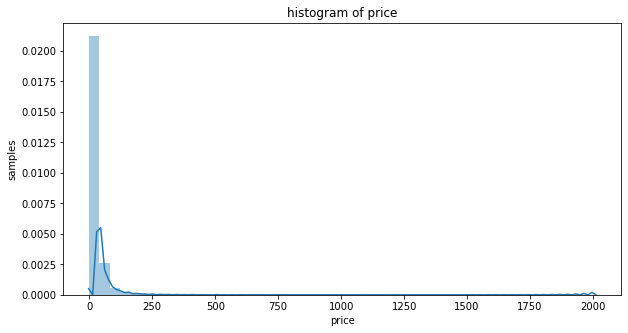

In [12]:
# Plotting the distribution of price.

plt.figure(figsize=(10,5))
sns.distplot(df['price'])
plt.title('histogram of price')
plt.xlabel('price')
plt.ylabel('samples')
plt.show()

Distribution of price is positive skewed. (it has long tail towards positive direction).

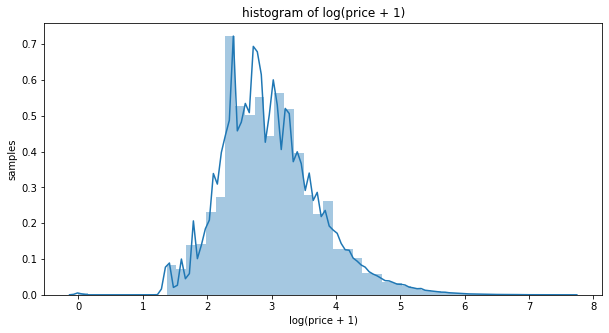

In [13]:
# Plotting the distribution of log1p.

plt.figure(figsize=(10,5))
sns.distplot(np.log1p(df['price']),)
plt.title('histogram of log(price + 1)')
plt.xlabel('log(price + 1)')
plt.ylabel('samples')
plt.show()

After applying log(p + 1) distribution looks almost like gaussian. We will be using this as our target variable.

In [14]:
# Creating new column log1p

df['log1p'] = df['price'].apply(np.log1p)
df.head(2)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,log1p
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,blank,10.0,1,No description yet,2.397895
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,3.970292


### Name

In [15]:
df['name'].describe()

count     1482535
unique    1225273
top        Bundle
freq         2232
Name: name, dtype: object

Name is almost unique. Except few thousand repeated values.

### What are frequent values in name field?

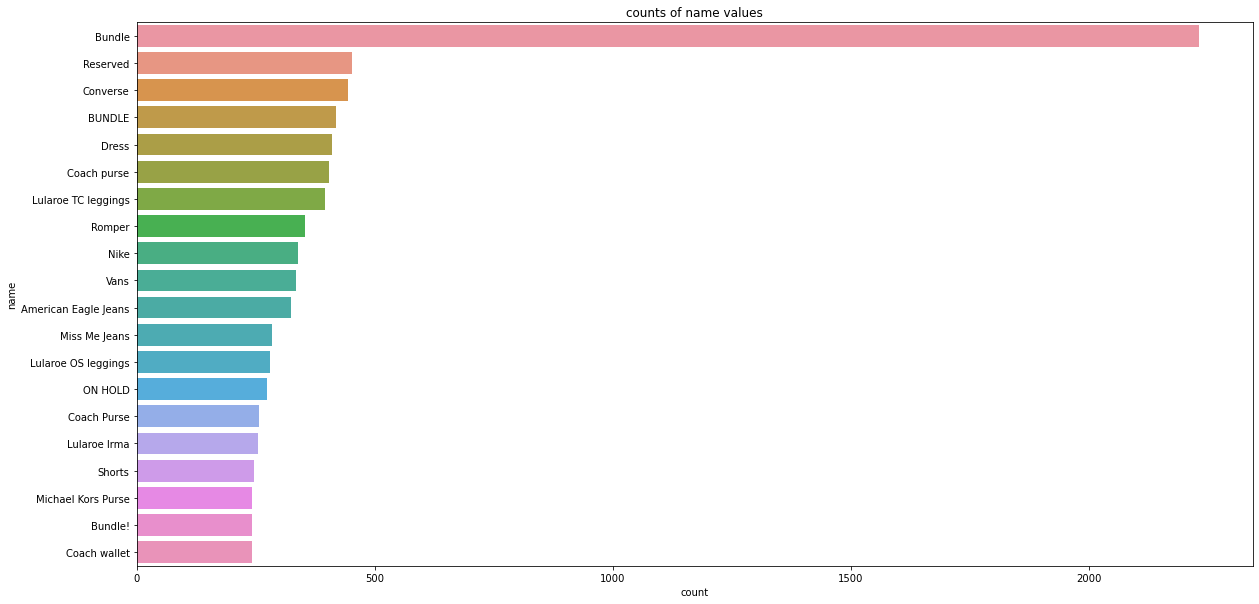

In [16]:
# Plotting countplot of name field.
# https://stackoverflow.com/questions/32891211/limit-the-number-of-groups-shown-in-seaborn-countplot

plt.figure(figsize = (20,10))
sns.countplot(y='name',data=df,order=pd.value_counts(df['name']).iloc[:20].index).set_title('counts of name values')

plt.show()

Some products use common words for product name like Bundle, Reserved, Dress. Some products when brand name has value, brand name is used as product name like Nike, Converse.

### Does length of the name has any effect on price?

In [17]:
# creating a new column,name_length.

df['name_length'] = df['name'].apply(len)
df.head(2)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,log1p,name_length
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,blank,10.0,1,No description yet,2.397895,35
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,3.970292,32


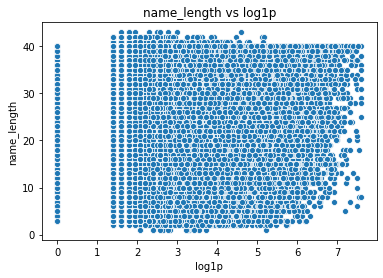

In [18]:
# scatter plot of name_length vs log1p

sns.scatterplot(df['log1p'], df['name_length'])
plt.title('name_length vs log1p')
plt.show()

There is no strong correlation between name length and price

**Category Name**

In [19]:
# frequent values in category column.

print('Top 10 frequent values:')
pd.value_counts(df['category_name']).iloc[:10]

Top 10 frequent values:


Women/Athletic Apparel/Pants, Tights, Leggings                 60177
Women/Tops & Blouses/T-Shirts                                  46380
Beauty/Makeup/Face                                             34335
Beauty/Makeup/Lips                                             29910
Electronics/Video Games & Consoles/Games                       26557
Beauty/Makeup/Eyes                                             25215
Electronics/Cell Phones & Accessories/Cases, Covers & Skins    24676
Women/Underwear/Bras                                           21274
Women/Tops & Blouses/Tank, Cami                                20284
Women/Tops & Blouses/Blouse                                    20284
Name: category_name, dtype: int64

Looks  like each value has 3 sub-categories. They are separated by '/'

In [20]:
# Create a function to split category column into subcategories.
# https://stackoverflow.com/questions/16236684/apply-pandas-function-to-column-to-create-multiple-new-columns

def category_split(sample):
        """ splits a string with / as separator into 3 substrings. if it is not a string returns nan"""

        if type(sample) == str:
            a,b,c = sample.split('/')[:3]
            return a,b,c
            #print(sub_cat1, sub_cat2, sub_cat3)
        else: 
            return np.nan, np.nan, np.nan

df['sub1'], df['sub2'], df['sub3'] = zip(*df['category_name'].apply(category_split))

In [21]:
df.head(2)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,log1p,name_length,sub1,sub2,sub3
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,blank,10.0,1,No description yet,2.397895,35,Men,Tops,T-shirts
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,3.970292,32,Electronics,Computers & Tablets,Components & Parts


In [22]:
print('no. of sub1 categories: ', len(pd.value_counts(df['sub1'])))

no. of sub1 categories:  11


### What is the frequency of different subcategories?

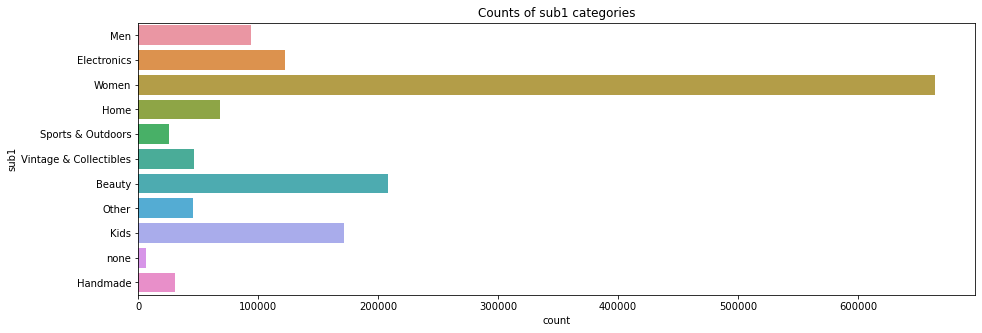

In [23]:
# Plotting countplot of sub1 categories.

plt.figure(figsize = (15, 5))
sns.countplot(y = df['sub1'])
plt.title('Counts of sub1 categories')
plt.show()

There are 11 main categories including none. Women category is most popular.

In [24]:
print('no. of sub2 categories: ', len(pd.value_counts(df['sub2'])) )

no. of sub2 categories:  114


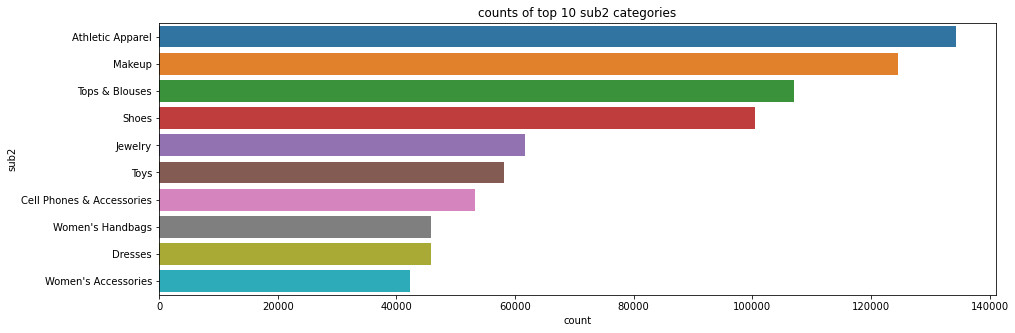

In [25]:
# Plotting countplot of sub2 categories.

plt.figure(figsize = (15,5))
sns.countplot(y='sub2',data=df,order=pd.value_counts(df['sub2']).iloc[:10].index)
plt.title('counts of top 10 sub2 categories')
plt.show()

There are 114 sub2 categories. Athletic is most popular.

In [26]:
print('no. sub3 categories: ', len(pd.value_counts(df['sub3'])))

no. sub3 categories:  871


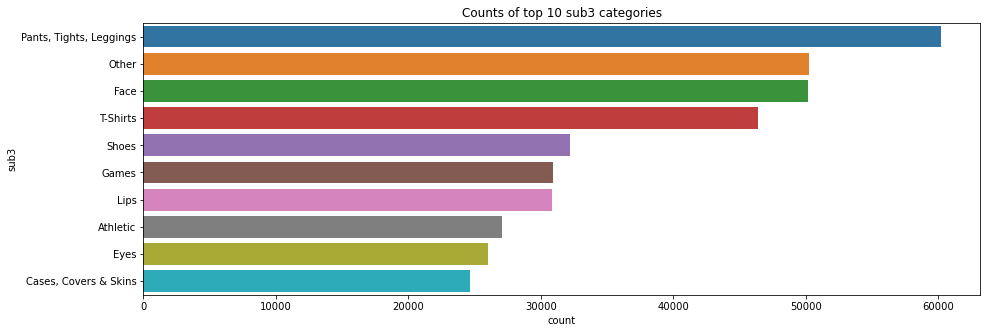

In [27]:
# Plotting count plot of sub3 categories.

plt.figure(figsize = (15,5))
sns.countplot(y='sub3',data=df,order=pd.value_counts(df['sub3']).iloc[:10].index)
plt.title('Counts of top 10 sub3 categories')
plt.show()

There are 871 sub3 categories. Pants, Tights, Leggings is most popular.

### How does log1p vary across each sub category?

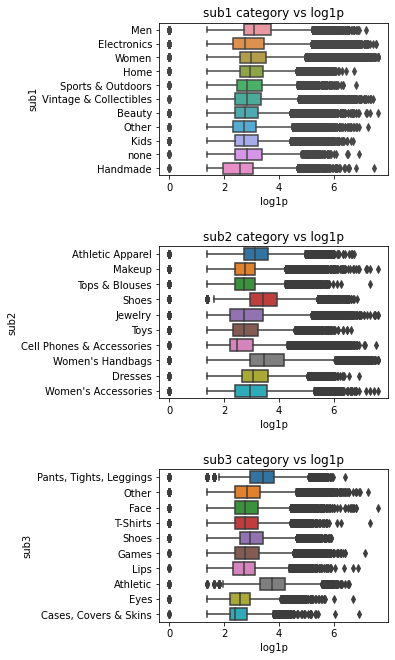

In [28]:
# Plotting boxplots each subcategory vs log1p.

fig, ax = plt.subplots(figsize = (5,10), nrows = 3, ncols = 1)
fig.tight_layout(pad=5.0)
ax = ax.flatten()

sns.boxplot(x = 'log1p', y = 'sub1', data = df, ax = ax[0]).set_title('sub1 category vs log1p')
sns.boxplot(x = 'log1p', y = 'sub2', data = df, order = pd.value_counts(df['sub2']).iloc[0:10].index, ax = ax[1]).set_title('sub2 category vs log1p')
sns.boxplot(x = 'log1p', y = 'sub3', data = df, order = pd.value_counts(df['sub3']).iloc[0:10].index, ax = ax[2]).set_title('sub3 category vs log1p')

plt.show()

price vary a lot based on different 3 sub categories.

### Does better item condition result in higher price with respect to different categories? 

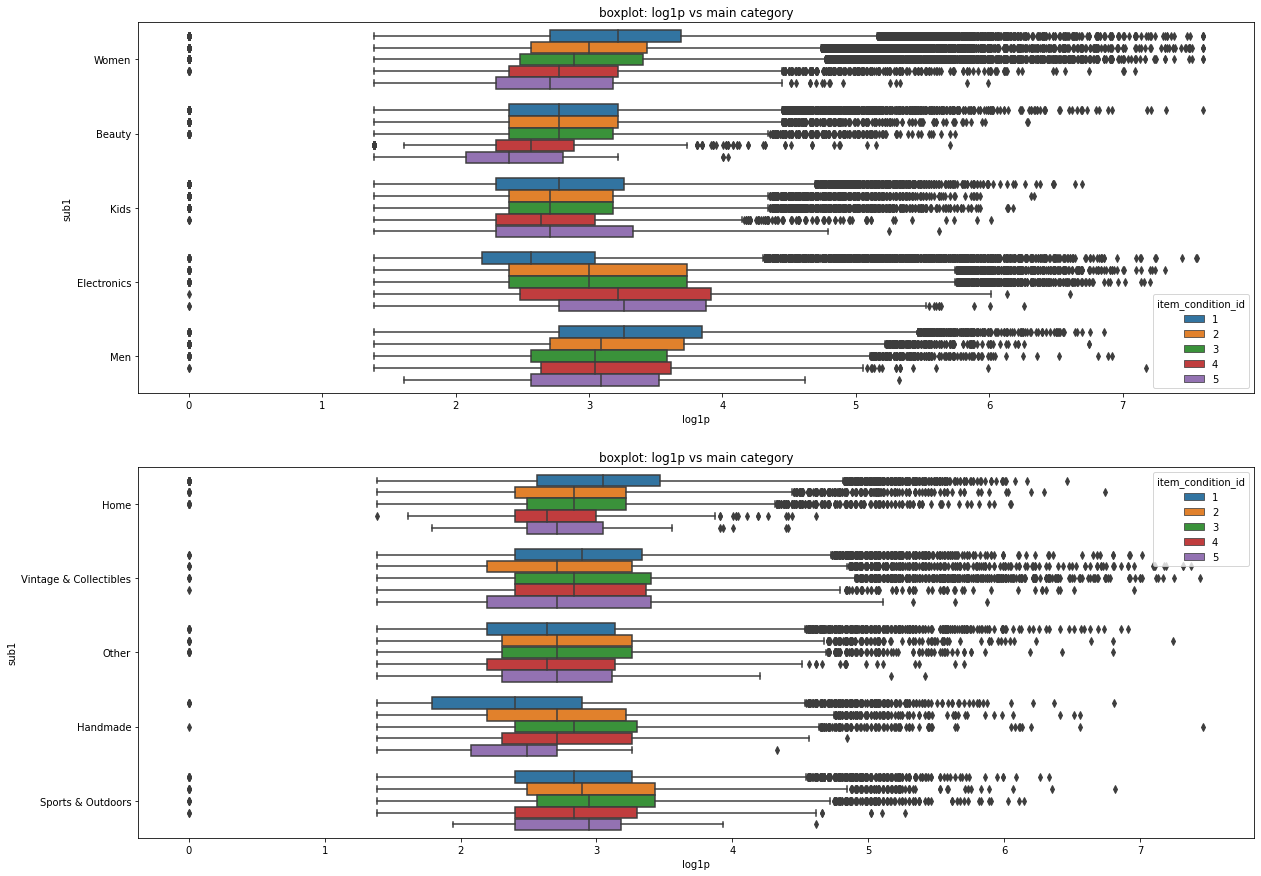

In [29]:
# Plotting 2 boxplots for sub1 category vs log1p.

fig, ax = plt.subplots(figsize = (20,15), nrows = 2, ncols = 1)
ax = ax.flatten()
sns.boxplot(y = 'sub1', x = 'log1p', data = df, hue = 'item_condition_id', order = pd.value_counts(df['sub1']).iloc[0:5].index, ax = ax[0]).set_title('boxplot: log1p vs main category')
sns.boxplot(y = 'sub1', x = 'log1p', data = df, hue = 'item_condition_id', order = pd.value_counts(df['sub1']).iloc[5:10].index, ax = ax[1]).set_title('boxplot: log1p vs main category')

plt.show()

For some categories(women, beauty), better item condition gives better price. For electronics, its reverse.

### What is the Median price of an item across each sub category?

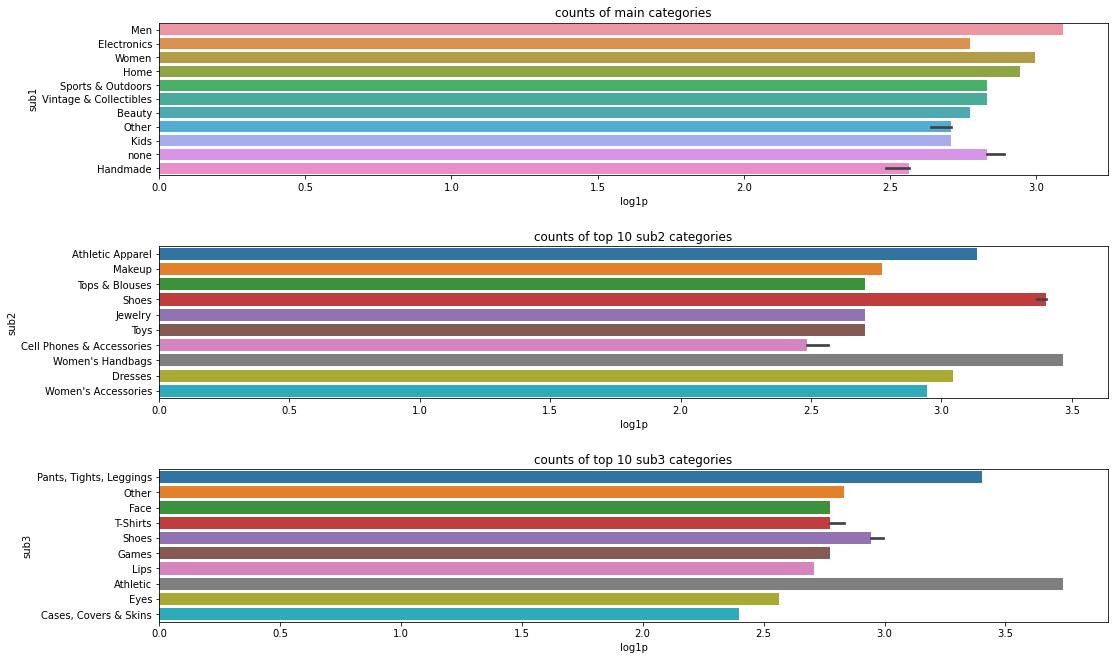

In [69]:
# Plotting bar plot with median estimator for each subcategory.

fig, ax = plt.subplots(figsize = (15,10), nrows = 3, ncols = 1, )
fig.tight_layout(pad=5.0)
ax = ax.flatten()
sns.barplot(y = 'sub1', x = 'log1p', data = df, estimator = median, ax = ax[0]).set_title('counts of main categories')
sns.barplot(y = 'sub2', x = 'log1p', data = df, estimator = median , order = pd.value_counts(df['sub2']).iloc[0:10].index, ax = ax[1]).set_title('counts of top 10 sub2 categories')
sns.barplot(y = 'sub3', x = 'log1p', data = df, estimator = median, order = pd.value_counts(df['sub3']).iloc[0:10].index, ax = ax[2] ).set_title('counts of top 10 sub3 categories')

plt.show()

As we go from main categories to sub categories, variation of median prices increases.

### Brand Name

In [31]:
df['brand_name'].describe()

count     1482535
unique       4810
top         blank
freq       632682
Name: brand_name, dtype: object

There are 4809 unique brands

### What are most popular brands?

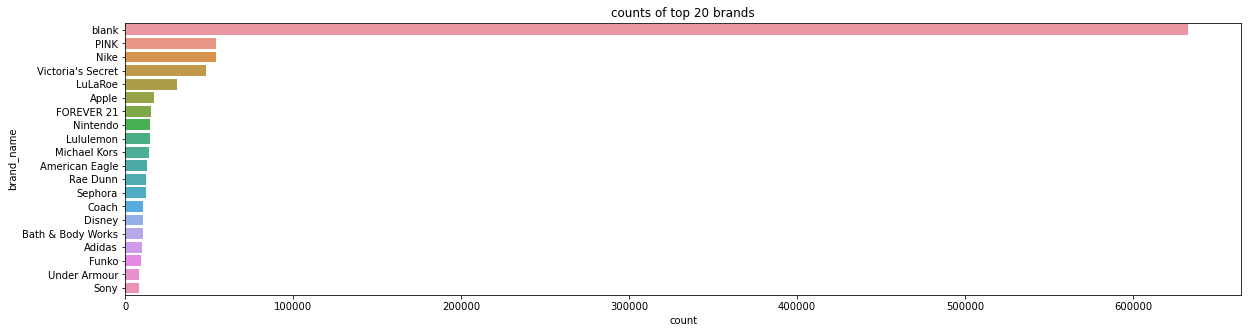

In [32]:
# Plotting countplot for top20 brands.

plt.figure(figsize = (20,5))
sns.countplot(y='brand_name',data=df,order=pd.value_counts(df['brand_name']).iloc[:20].index).set_title('counts of top 20 brands')
plt.show()

Significant number of products are not of any brand.

### How does log1p vary across each brand for different item_conditions?

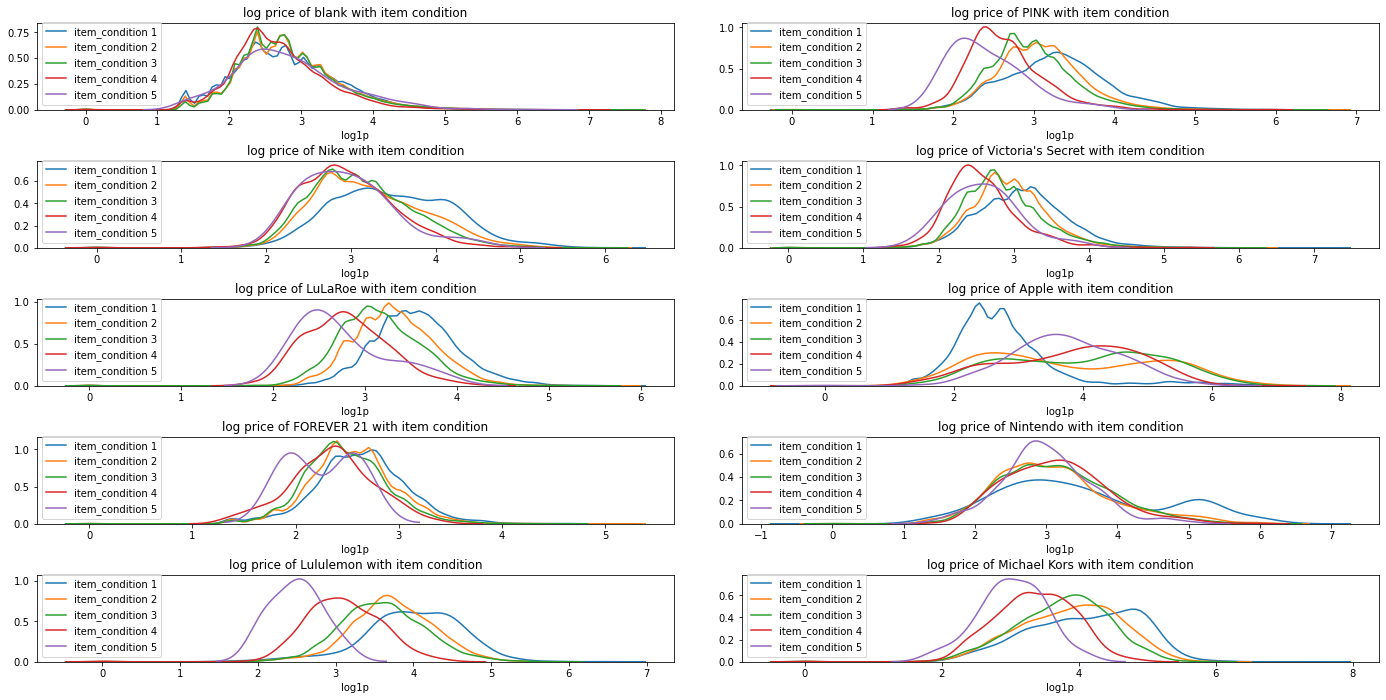

In [33]:
# Plotting displots of price for top 10 brands and differnt item_conditions.

fig, ax = plt.subplots(figsize=(20, 10), nrows=5, ncols=2,)
fig.tight_layout(pad=3.0)
i = 0
ax = ax.flatten()

for brand in pd.value_counts(df['brand_name']).iloc[:10].index:
    
    sns.distplot((df[(df['brand_name'] == brand) & (df['item_condition_id'] == 1)]['log1p']), ax = ax[i] , hist = False, label = 'item_condition 1')
    sns.distplot((df[(df['brand_name'] == brand) & (df['item_condition_id'] == 2)]['log1p']), ax = ax[i] , hist = False,label = 'item_condition 2')
    sns.distplot((df[(df['brand_name'] == brand) & (df['item_condition_id'] == 3)]['log1p']), ax = ax[i] , hist = False,label = 'item_condition 3')
    sns.distplot((df[(df['brand_name'] == brand) & (df['item_condition_id'] == 4)]['log1p']), ax = ax[i] , hist = False,label = 'item_condition 4')
    sns.distplot((df[(df['brand_name'] == brand) & (df['item_condition_id'] == 5)]['log1p']), ax = ax[i] , hist = False,label = 'item_condition 5')
    ax[i].legend()
    ax[i].set_title('log price of '+ str(brand) + ' with item condition')


    i+=1
plt.show()

Except for few brands like Apple and Blank, other brands shown above follow the pattern of best item condition costs more than worst item condition.

### What categories do no brand products belong to?

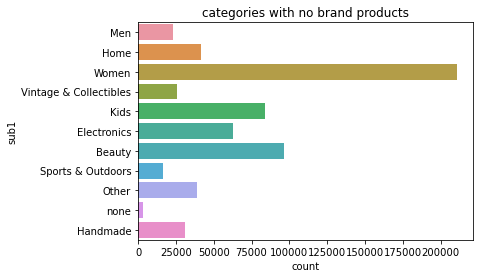

In [34]:
# Plotting countplot of categories in no brand products.

sns.countplot(y = 'sub1', data = df[df['brand_name']== 'blank'])
plt.title('categories with no brand products')
plt.show()

Products with no brand belong different categories hence the no clear pattern is observed with respect to log1p and item condition.

### Does branded products cost more than non branded products?

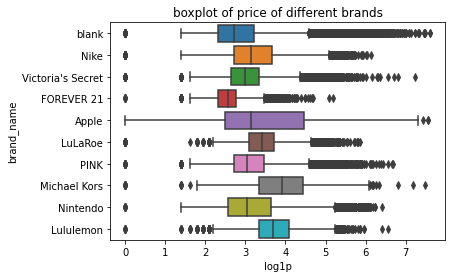

In [35]:
# Plotting box plot of price across different brands.

top10brands = df[df['brand_name'].isin(pd.value_counts(df['brand_name']).iloc[:10].index)]
sns.boxplot(data = top10brands, x = 'log1p', y = 'brand_name')
plt.title('boxplot of price of different brands')
plt.show()

Although median price of most brands is greater than non-branded products. But this doesn't show the clear picture, because non-branded products are part of many categories.

### How does log1p vary with brand_name across different categories?

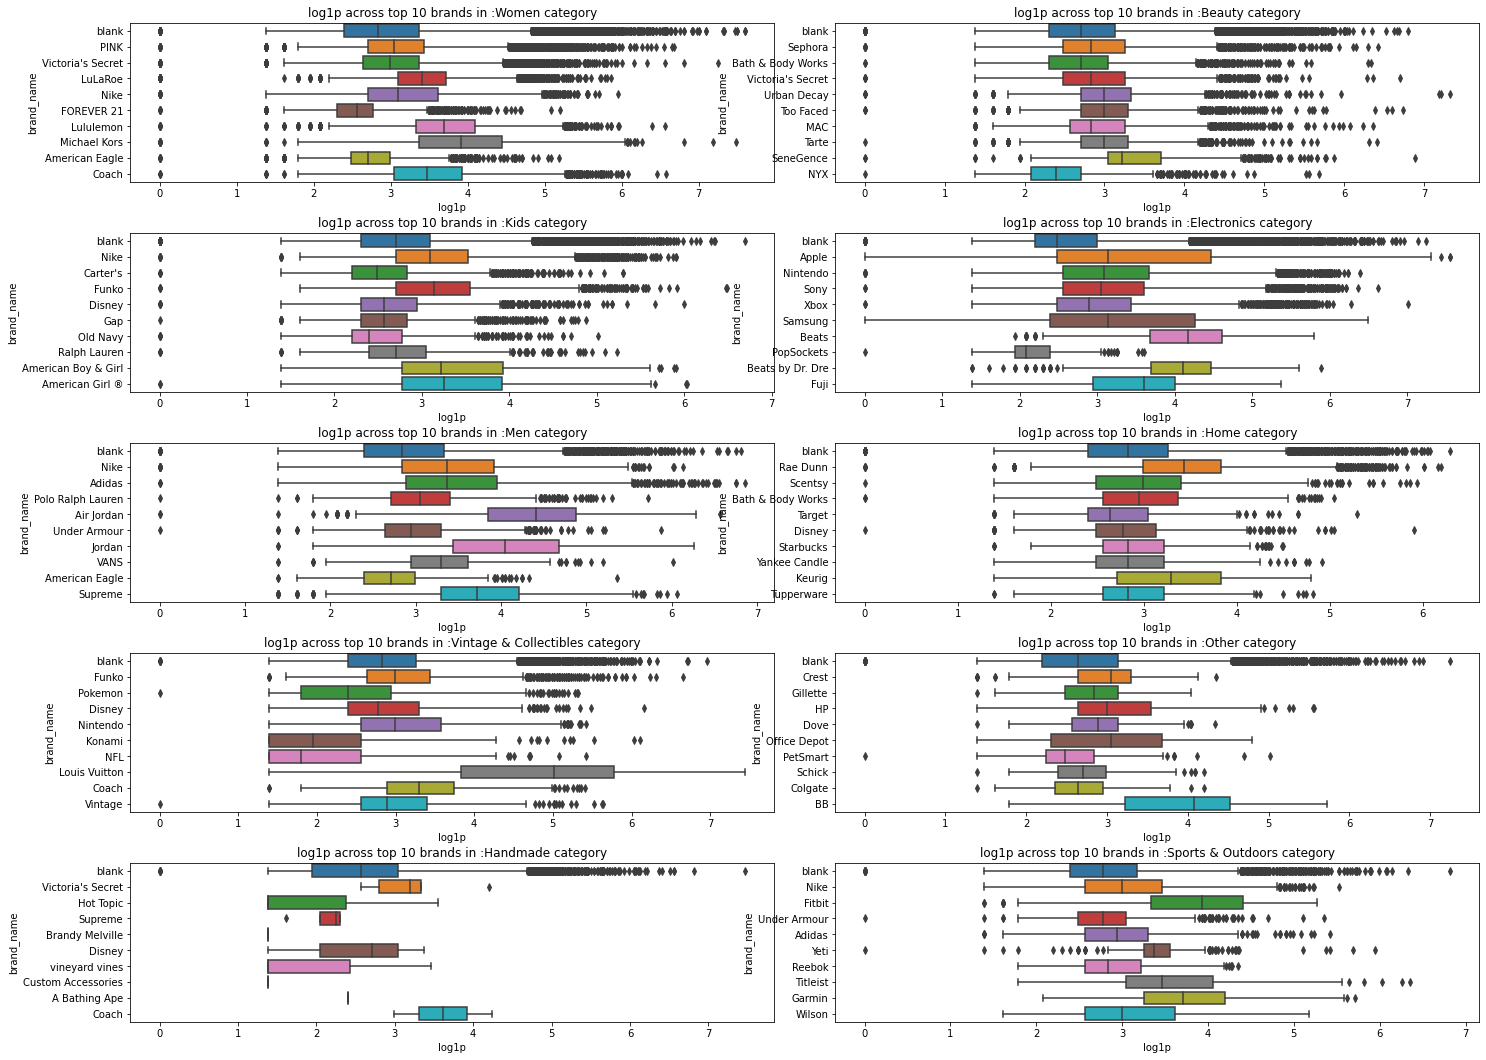

In [36]:
# Boxplots of price vs brands across different categories.

fig, ax = plt.subplots(figsize=(20, 15), nrows=5, ncols=2, )
fig.tight_layout(pad=3.0)
i = 0
ax = ax.flatten()

generalcat = pd.value_counts(df['sub1']).iloc[:10].index
generalcat
for cat in generalcat:
    df_cat = df[df['sub1'] == cat]
    top10brands_df = df_cat[df_cat['brand_name'].isin(pd.value_counts(df_cat['brand_name']).iloc[:10].index)]
    
    brands = pd.value_counts(df_cat['brand_name']).iloc[:10].index
    sns.boxplot(data = top10brands_df, x = 'log1p', y = 'brand_name', ax = ax[i], order = brands)
    ax[i].set_title('log1p across top 10 brands in :' + cat + ' category')
    i+=1
    
plt.show()

There are some brands that are valuable than no brand(example apple in electronics, victoria's secret in handmade), but also some brands are not valuable than no brand(carter's in kids). 

Some brands are valuable but some are not.

### Shipping

### What is the distribution of shipping?

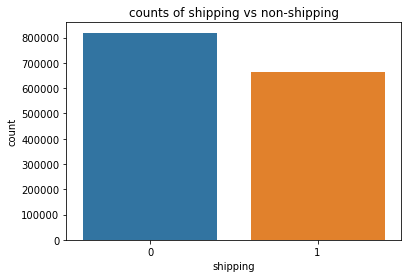

In [37]:
# Count plot of shipping.

sns.countplot(x = 'shipping', data = df).set_title('counts of shipping vs non-shipping')
plt.show()

### How does price vary with and without shipping?

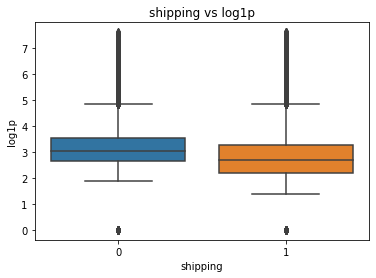

In [38]:
# Boxplot of log1p vs shipping.

sns.boxplot(data = df, y = 'log1p', x = 'shipping', ).set_title('shipping vs log1p')
plt.show()

median price of products with free shipping(1) is less than the products with shipping extra(0)

### Item_condition_id

### What is the distribution of item_condition_id?

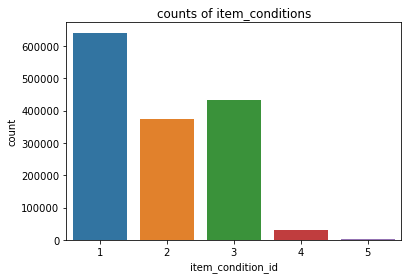

In [39]:
# plotting countplot of item_condition_id.

sns.countplot(df['item_condition_id']).set_title('counts of item_conditions')
plt.show()

Item_condition_id has 5 unique values. 1,2,3,4,5. 1 means best , 5 means worst condition of the product.

### How does price vary with item_condition?

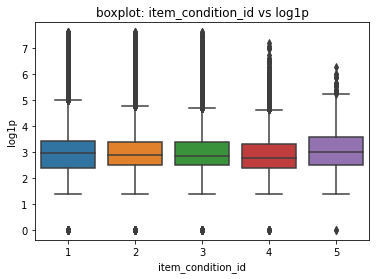

In [40]:
# Plotting boxplot of log1p vs item_condition_id.

sns.boxplot(data = df, y = 'log1p', x = 'item_condition_id').set_title('boxplot: item_condition_id vs log1p')

plt.show()

median price is almost same.

### Item Description

In [41]:
# Function to extract number from a string.

# https://www.geeksforgeeks.org/find-all-the-numbers-in-a-string-using-regular-expression-in-python/
import re
def extract_num(a):   
    
    """ Takes string as input and returns first number from it"""
    try:
        if(type(a)==str):

            return int(re.search('([0-9]+)', a).group())

        else:
            return np.nan 
    except:
        return np.nan
    

In [42]:
# Function to expand contracted words.

# https://stackoverflow.com/a/47091490/4084039 
import re 
def decontracted(phrase): 
    
    """ Takes string as input and expands if any of the below contractions are present."""
    # specific    
    phrase = re.sub(r"won't", "will not", phrase)    
    phrase = re.sub(r"can\'t", "can not", phrase)    
    # general    
    phrase = re.sub(r"n\'t", " not", phrase)    
    phrase = re.sub(r"\'re", " are", phrase)    
    phrase = re.sub(r"\'s", " is", phrase)    
    phrase = re.sub(r"\'d", " would", phrase)    
    phrase = re.sub(r"\'ll", " will", phrase)    
    phrase = re.sub(r"\'t", " not", phrase)    
    phrase = re.sub(r"\'ve", " have", phrase)    
    phrase = re.sub(r"\'m", " am", phrase)    
    return phrase


In [43]:
# Function to remove special characters and stopwords.

from tqdm.notebook import tqdm
stopwords = set(stopwords.words('english'))
stopwords.add('[rm]')

preprocessed_description = [] 
# tqdm is for printing the status bar 
for sentance in tqdm(df['item_description'].values):    
    sent = decontracted(sentance)    
    sent = sent.replace('\\r', ' ')    
    sent = sent.replace('\\"', ' ')    
    sent = sent.replace('\\n', ' ')    
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)      
    sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)    
    preprocessed_description.append(sent.lower().strip())
df['item_description'] = preprocessed_description

### Wordcloud of item description

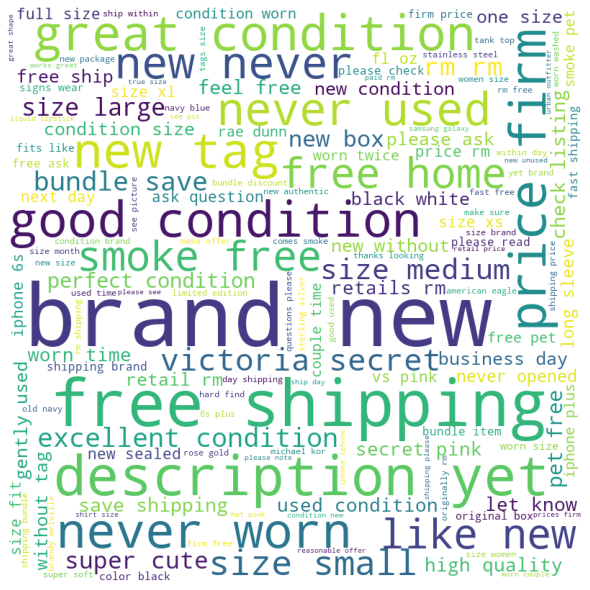

In [44]:
# Wordcloud to see frequent words in item_description.

import re
from wordcloud import WordCloud, STOPWORDS 
min_df = df.sample(frac = 1.0)
text = ' '.join(min_df['item_description'].tolist())
text = re.sub(r'==.*?==+', '', text)
text = text.replace('\n', '')


text = str(text)
stop = set(STOPWORDS) 
stop.add('[rm]') 
wordcloud = WordCloud(width = 800, height = 800,background_color ='white', stopwords = stop, min_font_size = 10).generate(text)  

# plot the WordCloud image                       
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0)   
plt.show() 

Brand and new are most frequent words. description, free shipping, price and firm are next.

## 3.1 Feature Engineering: extracting new features from item description

In [57]:
# Extracting new features like, number of words, length, number, has a number from item_description field.

# Extracting has a description, has brand, has category from respective fields.

# https://stackoverflow.com/questions/37483470/how-to-calculate-number-of-words-in-a-string-in-dataframe

# https://stackoverflow.com/questions/43485469/apply-textblob-in-for-each-row-of-a-dataframe

# https://stackoverflow.com/questions/29523254/python-remove-stop-words-from-pandas-dataframe

df['no.words'] = df['item_description'].str.split().str.len()
df['length'] = df['item_description'].apply(len)


df['subjectivity'] =  df['item_description'].apply(lambda word: TextBlob(word).sentiment.subjectivity)

df['number'] = df['item_description'].apply(extract_num)
df['number'].fillna(0, inplace = True)
df['hasnum'] = df['number'].astype(np.bool)

df['has_description'] = np.where(df['item_description'] == 'description yet', 0, 1)

df['has_brand'] = np.where(df['brand_name'] == 'blank', 0, 1)
df['has_category'] = np.where(df['category_name'] == 'none/none/none', 0, 1)
df['no_missing'] = df['has_description'] & df['has_brand'] & df['has_category']


df.head(2)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,log1p,name_length,...,length,subjectivity,number,hasnum,has_description,has_brand,has_category,no_missing,name_brand,text
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,blank,10.0,1,description yet,2.397895,35,...,15,0.000,0,False,0,0,1,0,MLB Cincinnati Reds T Shirt Size XL blank,description yet MLB Cincinnati Reds T Shirt Si...
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,keyboard great condition works like came box p...,3.970292,32,...,117,0.875,0,False,1,1,1,1,Razer BlackWidow Chroma Keyboard Razer,keyboard great condition works like came box p...


### How does log1p vary with new features?

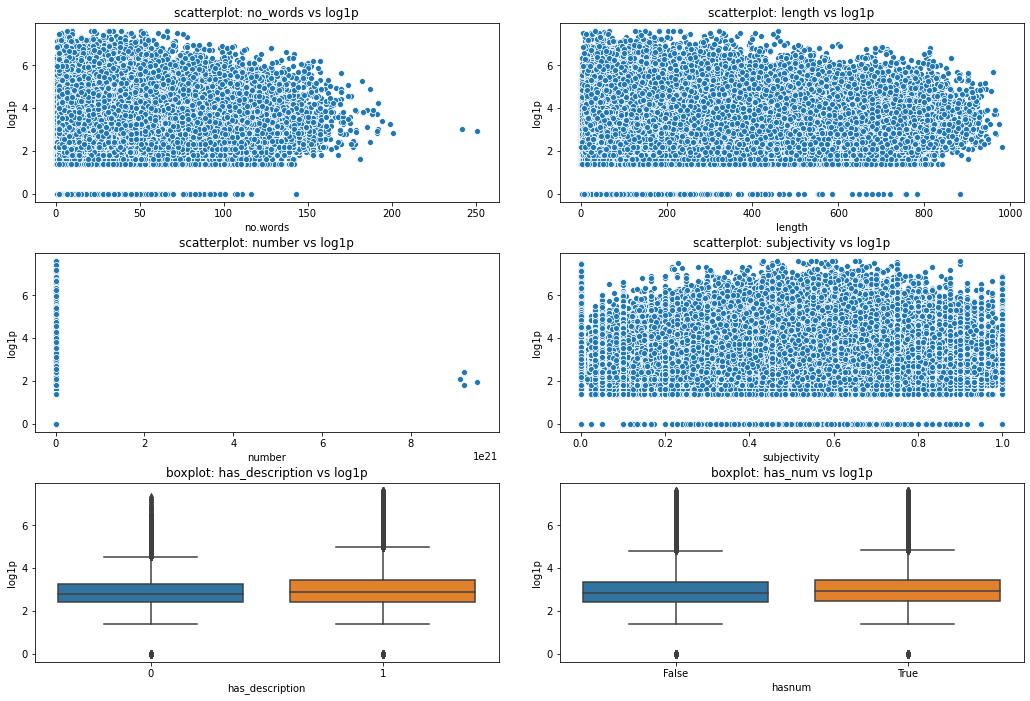

In [58]:
# Scatter plots for continous variables and boxplot for discreate variables vs price.

fig, ax = plt.subplots(figsize=(15, 10), nrows=3, ncols=2, )
fig.tight_layout(pad=3.0)
ax = ax.flatten()


sns.scatterplot(data = df, x = 'no.words', y = 'log1p', ax = ax[0]).set_title('scatterplot: no_words vs log1p')
sns.scatterplot(data = df, x = 'length', y = 'log1p', ax = ax[1]).set_title('scatterplot: length vs log1p')
sns.scatterplot(data = df, x = 'number', y = 'log1p', ax = ax[2]).set_title('scatterplot: number vs log1p')
sns.scatterplot(data = df, x = 'subjectivity', y = 'log1p', ax = ax[3]).set_title('scatterplot: subjectivity vs log1p')
sns.boxplot(data = df, y = 'log1p', x = 'has_description', ax = ax[4]).set_title('boxplot: has_description vs log1p')
sns.boxplot(data = df, y = 'log1p', x = 'hasnum', ax = ax[5]).set_title('boxplot: has_num vs log1p')
plt.show()

No clear pattern is observed for any of above features with respect to log1p. Except has_description feature, median log1p for products with description is slightly higher.

### How does log1p vary with missing features?

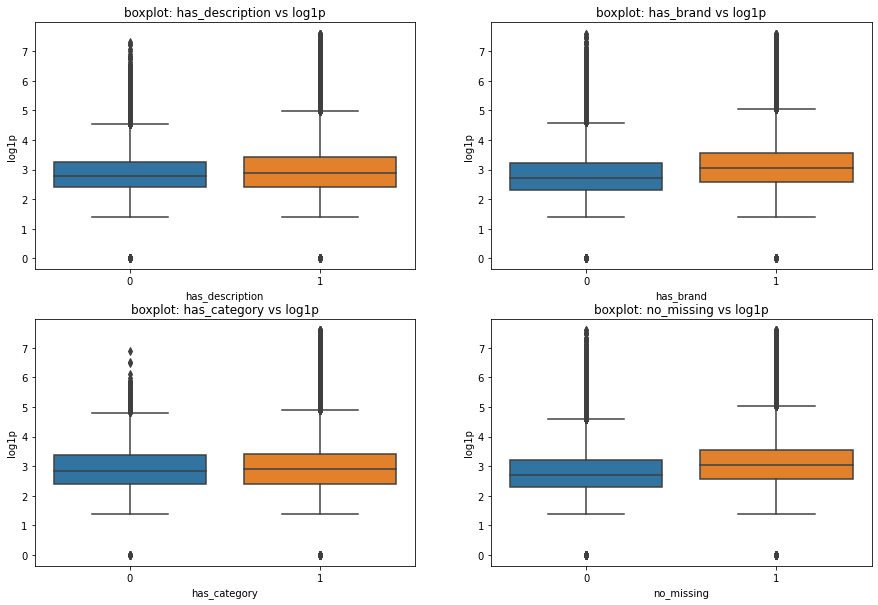

In [59]:
# boxplots for missing feature vs log1p.


fig, ax = plt.subplots(figsize=(15, 10), nrows=2, ncols=2, )
ax = ax.flatten()

sns.boxplot(data = df, y = 'log1p', x = 'has_description', ax = ax[0]).set_title('boxplot: has_description vs log1p')
sns.boxplot(data = df, y = 'log1p', x = 'has_brand', ax = ax[1]).set_title('boxplot: has_brand vs log1p')

sns.boxplot(data = df, y = 'log1p', x = 'has_category', ax = ax[2]).set_title('boxplot: has_category vs log1p')
sns.boxplot(data = df, y = 'log1p', x = 'no_missing', ax = ax[3]).set_title('boxplot: no_missing vs log1p')
plt.show()

Median price of products with no missing values is higher than the products with missing values.

### What's the correlation among columns of the dataset?

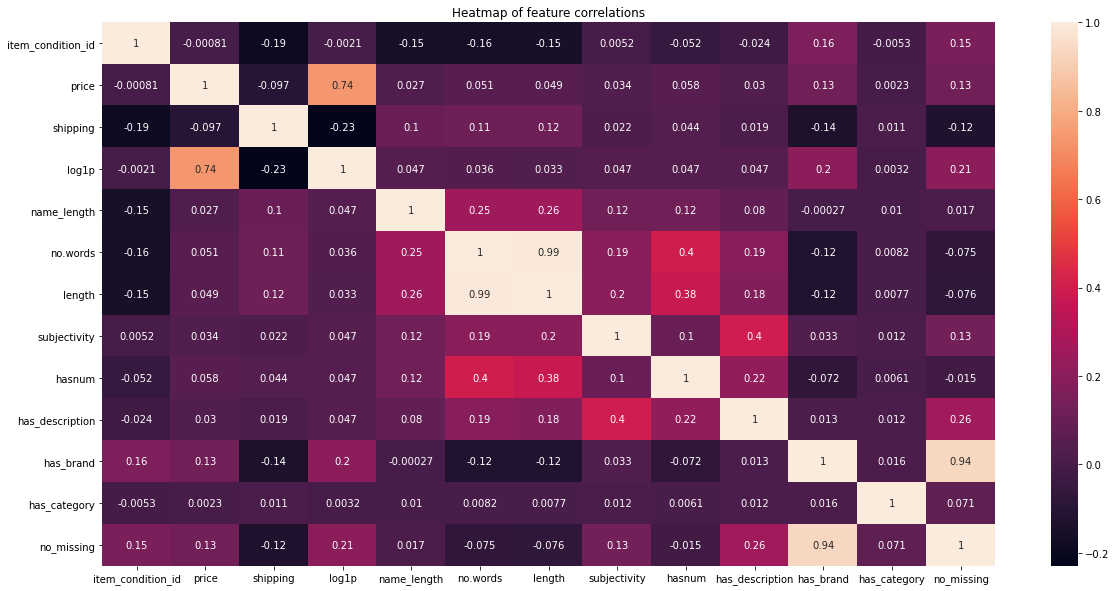

In [60]:
# Heatmap of correlation factor across all numeric columns.

plt.figure(figsize=(20,10))
sns.heatmap(df.drop(['train_id'], axis = 1).corr(), annot = True).set_title('Heatmap of feature correlations')
plt.show()

no_missing value shows good correlation with log1p among the new features.

In [61]:
df.columns

Index(['train_id', 'name', 'item_condition_id', 'category_name', 'brand_name',
       'price', 'shipping', 'item_description', 'log1p', 'name_length', 'sub1',
       'sub2', 'sub3', 'no.words', 'length', 'subjectivity', 'number',
       'hasnum', 'has_description', 'has_brand', 'has_category', 'no_missing',
       'name_brand', 'text'],
      dtype='object')

In [62]:
df.head(2)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,log1p,name_length,...,length,subjectivity,number,hasnum,has_description,has_brand,has_category,no_missing,name_brand,text
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,blank,10.0,1,description yet,2.397895,35,...,15,0.000,0,False,0,0,1,0,MLB Cincinnati Reds T Shirt Size XL blank,description yet MLB Cincinnati Reds T Shirt Si...
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,keyboard great condition works like came box p...,3.970292,32,...,117,0.875,0,False,1,1,1,1,Razer BlackWidow Chroma Keyboard Razer,keyboard great condition works like came box p...


## 3.2 Feature Engineering: merging fields into one

In [63]:
# Creating new fields by merging existing ones.

df['name_brand'] = df['name'] + " " + df['brand_name']

df['text'] = df['item_description'] + " " + df['name'] + " " + df['category_name']

## 4.Vectorization

In [64]:
# Using TFIDF to vectorize name_brand and text fields.

vectorizer = TfidfVectorizer(max_features=80000, )

name_brand = vectorizer.fit_transform(df['name_brand'])

vectorizer = TfidfVectorizer(max_features=100000,  ngram_range = (1,2))

text = vectorizer.fit_transform(df['text'])


In [66]:
# using minmaxscaler and standerscaler to vectorize remaining fields.

item_condition = MinMaxScaler().fit_transform(df['item_condition_id'].values.reshape(1,-1))

item_condition = item_condition.reshape(-1,1)

shipping = df['shipping'].values.reshape(-1,1)

no_words = StandardScaler().fit_transform(df['no.words'].values.reshape(1,-1))

no_words = no_words.reshape(-1,1)



length = StandardScaler().fit_transform(df['length'].values.reshape(1,-1))

length = length.reshape(-1,1)


name_length = StandardScaler().fit_transform(df['name_length'].values.reshape(1,-1))

name_length = name_length.reshape(-1,1)



subjectivity = StandardScaler().fit_transform(df['subjectivity'].values.reshape(1,-1))

subjectivity = subjectivity.reshape(-1,1)

number = StandardScaler().fit_transform(df['number'].values.reshape(1,-1))

number = number.reshape(-1,1)

hasnum = df['hasnum'].values.reshape(-1,1)

has_description = df['has_description'].values.reshape(-1,1)

has_brand = df['has_brand'].values.reshape(-1,1)

has_category = df['has_category'].values.reshape(-1,1)

no_missing = df['no_missing'].values.reshape(-1,1)

In [67]:
# Using hstack to merge all the fields.

x = hstack([name_brand, text, item_condition,
        shipping,  no_words, length,
       name_length, subjectivity, number, hasnum,
        has_description, has_brand, has_category, no_missing ])

y = df['log1p'].values

In [68]:
x.shape

(1482535, 180012)